In [1]:
import pandas as pd
import numpy as np
import flip_data
import enet_gd_poisoner
import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
poi_train_x = np.matrix(poi_train_x.to_numpy())
poi_train_y = pd.read_csv('train_y.csv')
poi_train_y = poi_train_y['Life Expectancy'].tolist()
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
print ("Train count: ", train_ct, " Test count: ", test_ct)

Train count:  1319  Test count:  165


In [3]:
def compute_error(classifier, plot, poisoned):
    # Compute predicted values
    test_y_pred = classifier.predict(poi_test_x)
    valid_y_pred = classifier.predict(poi_val_x)
    if (plot is True):
        plt.scatter(poi_test_y, test_y_pred)
        if (poisoned is True):
            plt.title("Flipped & Poisoned")
        else:
            plt.title("Flipped")
        plt.xlabel("Testing Data")
        plt.ylabel("Testing Predicted")
        plt.show()
        plt.scatter(poi_val_y, valid_y_pred)
        plt.xlabel("Validation Data")
        plt.ylabel("Validation Predicted")
        plt.show()
    # Compute squared errors
    test_mse = np.mean((test_y_pred - poi_test_y) ** 2)
    valid_mse = np.mean((valid_y_pred - poi_val_y) ** 2)
    return valid_mse, test_mse

# Inverse Flip & Elastic Network Poisoner

classifier:  ElasticNetCV(max_iter=10000)


*****************************
**** Poison Count:  54  ****
*****************************
Initial Iteration 
Current Loss:  0.00704696579510299
Validation MSE  0.005522286349379449 
Test MSE  0.007379552471929876
 
Iteration  1
Loss: 0.0061589239169505955  Difference:  -0.0008880376541118727
NO PROGRESS MADE!
 
Iteration  2
Loss: 0.006158943951625553  Difference:  -0.0008880176156077198
NO PROGRESS MADE!
 
Iteration  3
Loss: 0.00615896214719321  Difference:  -0.0008879994169883679
NO PROGRESS MADE!
 
Iteration  4
Loss: 0.006158978288144821  Difference:  -0.0008879832670610124
NO PROGRESS MADE!
 
Iteration  5
Loss: 0.006158991542553196  Difference:  -0.00088797000985437
NO PROGRESS MADE!
 
Poisoned classifier:  ElasticNet(alpha=7.432486579840555e-05, max_iter=10000, warm_start=True) , 
Returned lambda:  7.432486579840555e-05
Total running time (seconds): 0.644663

Poison Proportion:  4.0 %

After Flipping, Unpoisoned 
 Validation MSE:  0.004979

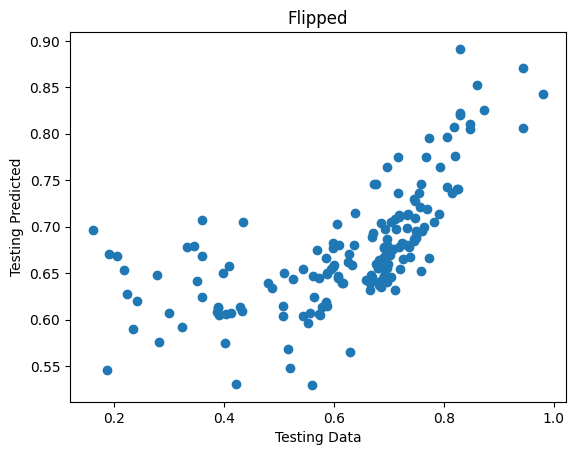

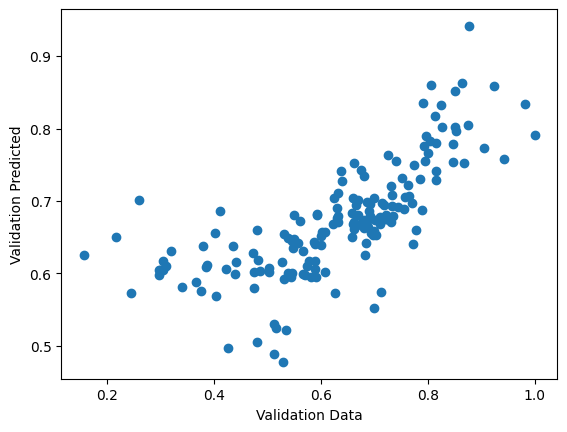

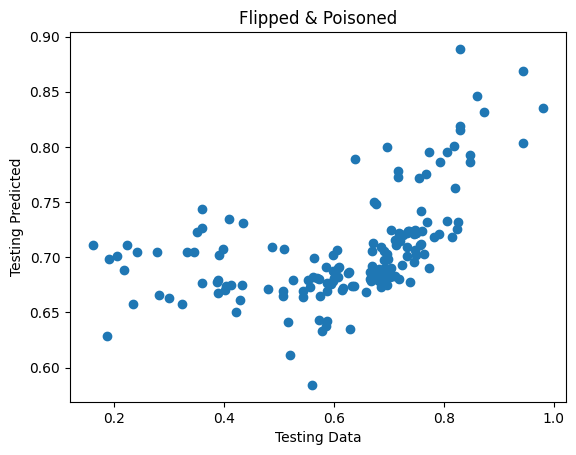

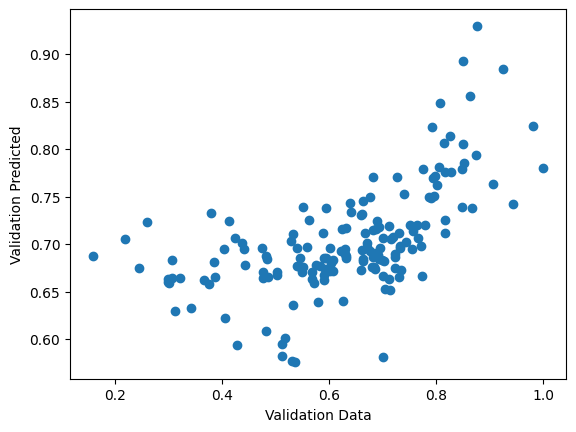


Poison Proportion:  20.0 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.016134621865561704 
 Test MSE: 0.021256997410968755

After Flipping & Poisoning:
 Validation MSE:  0.024419972942392742 
 Test MSE: 0.02964760486347142


In [4]:
# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-4 # poisoning stop condition
stop1 = 3
stop2 = 10
stop3 = 5
decrease_rate = 0.85
poiser = enet_gd_poisoner.poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in [0.04, 0.08, 0.12, 0.16, 0.20]:
    # calculate the amt of data that should be poisoned in this iteration
    sample_amt = int(train_ct*(i/(1 - i)))
    # flip the data
    x_flip, y_flip = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,sample_amt)
    classifier = linear_model.ElasticNetCV(max_iter=10000)
    classifier.fit(np.vstack((poi_train_x, x_flip)), poi_train_y + y_flip,)
    print("classifier: ", classifier)
    err = compute_error(classifier,False,False)[0]
    # Get the current time before running the code
    start_time = datetime.datetime.now()
    # poison data
    x_pois_result, y_pois_result, lam = poiser.poison_data(np.matrix(x_flip), y_flip[:],stop1, stop2, stop3, decrease_rate)
    x_poised = np.vstack((poi_train_x,x_pois_result))
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised = linear_model.ElasticNet(alpha=lam, max_iter=10000,warm_start=True)
    classifier_poised.fit(x_poised,y_poised)
    # Get the current time after running the code
    end_time = datetime.datetime.now()
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    # Calculate the difference between the start and end times
    time_diff = end_time - start_time
    print("Total running time (seconds):", time_diff.total_seconds())
    classifier = poiser.classifier
    if i != 0.20:
        err_unpoised = compute_error(classifier,False,False)
        err = compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", i*100,"%")
    else:
        err_unpoised = compute_error(classifier,True,False)
        err = compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", i*100, "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# B Flip & Elastic Network Poisoner

classifier:  ElasticNetCV(max_iter=10000)


*****************************
**** Poison Count:  54  ****
*****************************
Initial Iteration 
Current Loss:  0.0057615980371174425
Validation MSE  0.005001157645706382 
Test MSE  0.005883383040993464
 
Iteration  1
Loss: 0.005223037637900271  Difference:  -0.0005385581955115936
NO PROGRESS MADE!
 
Iteration  2
Loss: 0.0052228166229080055  Difference:  -0.0005387792102714891
NO PROGRESS MADE!
 
Iteration  3
Loss: 0.0052226323780427885  Difference:  -0.000538963454926788
NO PROGRESS MADE!
 
Iteration  4
Loss: 0.005222475925267199  Difference:  -0.0005391199075238558
NO PROGRESS MADE!
 
Iteration  5
Loss: 0.005222339984198209  Difference:  -0.0005392558484101917
NO PROGRESS MADE!
 
Poisoned classifier:  ElasticNet(alpha=7.432486579840555e-05, max_iter=10000, warm_start=True) , 
Returned lambda:  7.432486579840555e-05
Total running time (seconds): 0.614618

Poison Proportion:  4.0 %

After Flipping, Unpoisoned 
 Validation MSE:  0.0

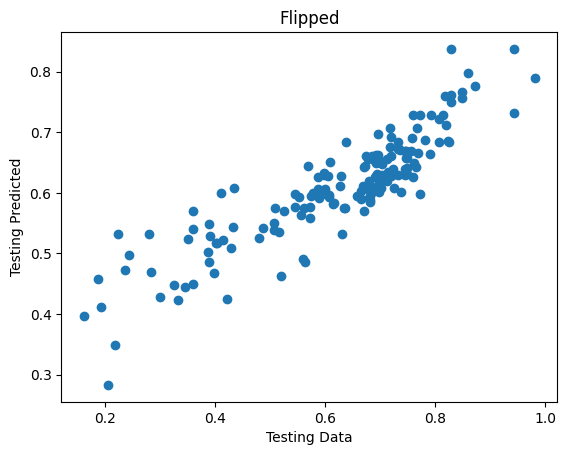

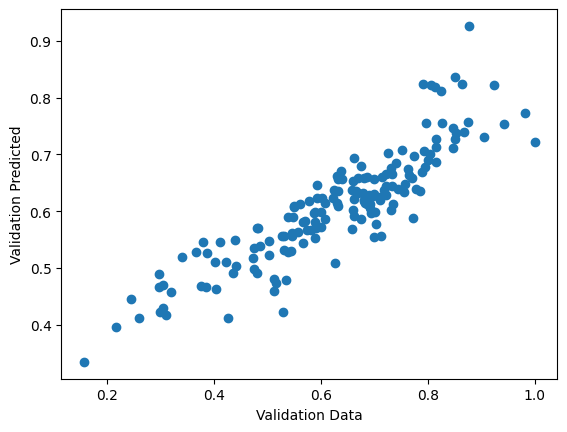

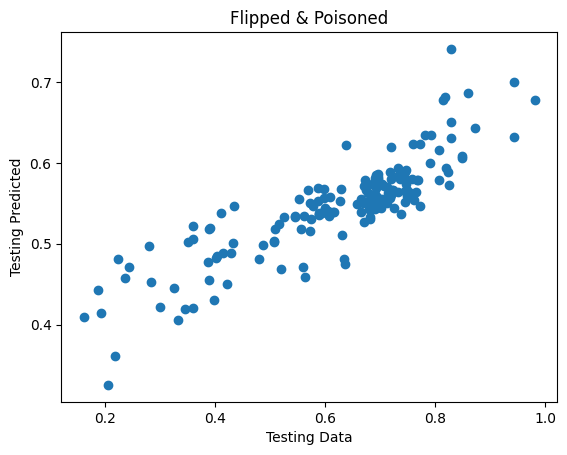

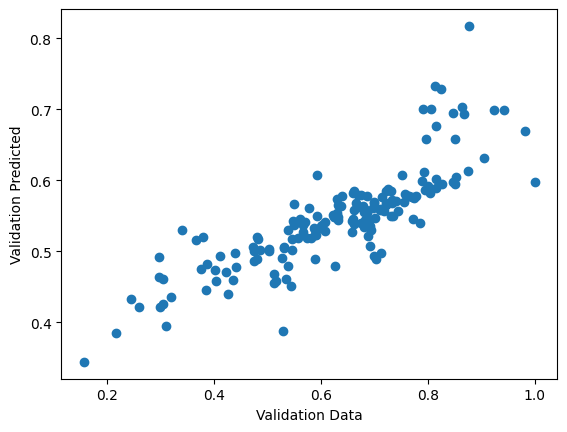


Poison Proportion:  20.0 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.008231187540361314 
 Test MSE: 0.009992984849071648

After Flipping & Poisoning:
 Validation MSE:  0.019486698890649468 
 Test MSE: 0.020334281802464445


In [5]:
poiser = enet_gd_poisoner.poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in [0.04, 0.08, 0.12, 0.16, 0.20]:
    # calculate the amt of data that should be poisoned in this iteration
    sample_amt = int(train_ct*(i/(1 - i)))
    # flip the data
    x_flip, y_flip = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,sample_amt)
    classifier = linear_model.ElasticNetCV(max_iter=10000)
    classifier.fit(np.vstack((poi_train_x, x_flip)), poi_train_y + y_flip,)
    print("classifier: ", classifier)
    err = compute_error(classifier,False,False)[0]
    # Get the current time before running the code
    start_time = datetime.datetime.now()
    # poison data
    x_pois_result, y_pois_result, lam = poiser.poison_data(np.matrix(x_flip), y_flip[:],stop1, stop2, stop3, decrease_rate)
    x_poised = np.vstack((poi_train_x,x_pois_result))
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised = linear_model.ElasticNet(alpha=lam, max_iter=10000,warm_start=True)
    classifier_poised.fit(x_poised,y_poised)
    # Get the current time after running the code
    end_time = datetime.datetime.now()
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    # Calculate the difference between the start and end times
    time_diff = end_time - start_time
    print("Total running time (seconds):", time_diff.total_seconds())
    classifier = poiser.classifier
    if i != 0.20:
        err_unpoised = compute_error(classifier,False,False)
        err = compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", i*100,"%")
    else:
        err_unpoised = compute_error(classifier,True,False)
        err = compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", i*100, "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])